# Makarna Üretim Problemi #
Bu eğitimde, IBM'in eğitim için hazırladığı örneklerden biri olan Makarna Üretim Problemini (The Pasta Production) DOcplex ile çözeceğiz. Bu eğitim hazırlanırken, <a href="https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/mp/jupyter/pasta_production.ipynb"> Viu-Long Kong tarafından hazırlanan notebook'tan </a> faydalanılmıştır. Önceki problemlerden bir tık daha zor olan ama yine de kolay sayılacak bir problemi çözmeye çalışacağız. 


## Problem ##
Daha önce defalarca tekrarladığımız bir cümle var. Bir model ezbere kurulmaz. Modeli kurmak için öncelikle problemi çok iyi anlamamız gerekiyor. Eğer problemi anlarsak modeli rahatlıkla kurabiliriz.

Makarna üreten bir fabrikamız bulunuyor. Bu fabrika iki şekilde üretim yapabilmektedir.
<ul>
    <li>Kendi fabrikasında (inside production)</li>
    <li>Taşeron firmalarda (outside production)</li>
</ul>

Fabrika 3 çeşit makarna üretmektedir. Kluski, Capellini ve Fettucine. Her bir makarnanın reçetesi farklıdır ve farklı karışımlarda hammaddeler tüketmektedir.

Üretim ise iki şekilde yapılmaktadır.<br>
Kendi fabrikasında yaptığı üretimlerde, hammadde kaynağı kısıtlıdır.<br>
Taşeron firmalarda yaptığı üretimerde ise kısıt üretim adetleridir. <br>

Amacımız, <br>
<ul>
    <li>Müşteri talebini karşılarken</li>
    <li>Üretim maliyetini minimize ederken</li>
    <li>Kaynak ve taşeron kısıtlarını aşmayacak şekilde</li>
</ul>
Her bir çeşit makarnadan kendi fabrikamızda ve taşeronda ne kadar üretim yapacağımıza karar vermemiz gerekiyor.

Bence problemi güzel özetledik. Aşağıda problemin daha da güzel bir özeti bulunuyor.

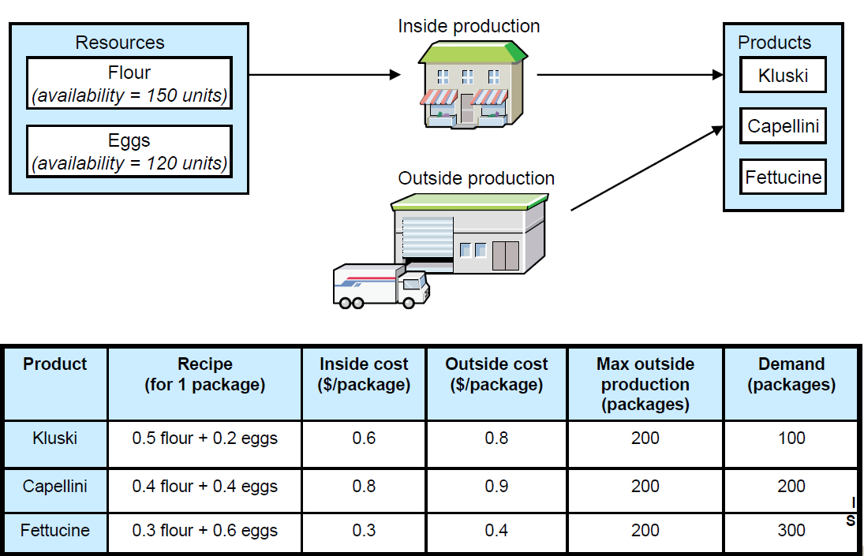



## DOcplex ile çözüm ##
__Kütüphaneler__

In [1]:
import cplex
import docplex.mp

__Data__<br>
Yukarıda tabloda verilen değerleri veri yapılarına alıyoruz.

In [2]:
products = [("kluski", 100, 0.6, 0.8),
            ("capellini", 200, 0.8, 0.9),
            ("fettucine", 300, 0.3, 0.4)]

# resources are a list of simple tuples (name, capacity)
resources = [("flour", 20),
             ("eggs", 40)]

consumptions = {("kluski", "flour"): 0.5,
                ("kluski", "eggs"): 0.2,
                ("capellini", "flour"): 0.4,
                ("capellini", "eggs"): 0.4,
                ("fettucine", "flour"): 0.3,
                ("fettucine", "eggs"): 0.6}

__Modelin kurulması__

In [3]:
from docplex.mp.model import Model
mdl = Model(name="pasta")

__Karar değişkenlerin tanımlanması__

In [4]:
inside_vars = mdl.continuous_var_dict(products, name='inside')
outside_vars = mdl.continuous_var_dict(products, name='outside')

__Kısıtların yazılması__<br>
Her bir ürün kendi fabrikamızda ya da taşeronda üretilmelidir.

In [5]:
# demand satisfaction
mdl.add_constraints((inside_vars[prod] + outside_vars[prod] >= prod[1], 'ct_demand_%s' % prod[0]) for prod in products)

[docplex.mp.LinearConstraint[ct_demand_kluski](inside_kluski_100_0.6_0.8+outside_kluski_100_0.6_0.8,GE,100),
 docplex.mp.LinearConstraint[ct_demand_capellini](inside_capellini_200_0.8_0.9+outside_capellini_200_0.8_0.9,GE,200),
 docplex.mp.LinearConstraint[ct_demand_fettucine](inside_fettucine_300_0.3_0.4+outside_fettucine_300_0.3_0.4,GE,300)]

Kendi fabrikamızda ürettiğimiz ürünler için hammadde kaynağı limitleri kadar üretim yapabiliriz. Taşeron için bir kaynak kısıdı olmadığı için ona ait bir kısıt yazmayacağız.

In [6]:
# --- resource capacity ---
mdl.add_constraints((mdl.sum(inside_vars[p] * consumptions[p[0], res[0]] for p in products) <= res[1], 'ct_res_%s' % res[0]) for res in resources)


[docplex.mp.LinearConstraint[ct_res_flour](0.500inside_kluski_100_0.6_0.8+0.400inside_capellini_200_0.8_0.9+0.300inside_fettucine_300_0.3_0.4,LE,20),
 docplex.mp.LinearConstraint[ct_res_eggs](0.200inside_kluski_100_0.6_0.8+0.400inside_capellini_200_0.8_0.9+0.600inside_fettucine_300_0.3_0.4,LE,40)]

Şu ana kadar modelimizin durumunu sorgulayalım.

In [7]:
mdl.print_information()

Model: pasta
 - number of variables: 6
   - binary=0, integer=0, continuous=6
 - number of constraints: 5
   - linear=5
 - parameters: defaults
 - objective: none
 - problem type is: LP


__Amaç Fonksiyonu__<br>
Amacımız, müşterinin taleplerini karşılarken maliyetlerin minimize edilmesidir.

In [8]:
total_inside_cost = mdl.sum(inside_vars[p] * p[2] for p in products)
total_outside_cost = mdl.sum(outside_vars[p] * p[3] for p in products)

mdl.minimize(total_inside_cost + total_outside_cost)

__Modelin Çözümü__<br>
Modeli çözmek için __Model.solve()__ fonksiyonunu çalıştırıyoruz.

In [9]:
mdl.solve()

docplex.mp.solution.SolveSolution(obj=372,values={inside_kluski_100_0.6_..

__Model sonuçlarının detaylandırılması__<br>

In [10]:
obj = mdl.objective_value

print("* Production model solved with objective: {:g}".format(obj))
print("* Total inside cost=%g" % total_inside_cost.solution_value)
for p in products:
    print("Inside production of {product}: {ins_var}".format(product=p[0], ins_var=inside_vars[p].solution_value))
print("* Total outside cost=%g" % total_outside_cost.solution_value)
for p in products:
    print("Outside production of {product}: {out_var}".format(product=p[0], out_var=outside_vars[p].solution_value))

* Production model solved with objective: 372
* Total inside cost=24
Inside production of kluski: 40.0
Inside production of capellini: 0
Inside production of fettucine: 0
* Total outside cost=348
Outside production of kluski: 60.0
Outside production of capellini: 200.0
Outside production of fettucine: 300.0


Bu eğitimde örnek bir problemin çözümünü inceledik. Arraylerimizde bulunan girdilerimizi kullanarak, karar değişkenlerimizi ve kısıtlarımızı otomatik tek satırlık komutlarla oluşturduk ve isimlendirdik. <br>
Model sonuçlarını daha detaylı görebilmek için yazdığımız komutlar sayesinde sonuçları daha rahat inceleyebildik.<br>
Bir sonraki eğitimde görüşmek üzere. 

__Sabri Suyunu__